**<h1 align="center">SIEMENS SALES FORECAST</h1>**

1. What is the objective of the model?

> We are tasked with creating a `monthly sales forecast`model for a subset of products from one Siemens business unit in Germany.

2. What data is available?

>Daily sales for specific product groups; <br>
>Macroeconomic features (indices for energy prices, raw materials, etc...)

3. How will the project be assessed?

> The model will be assessed quantitatively based on RMSE, plus there will be a quanlitative component (presentation and code review)

The `stakeholders` in this project are the management team in SIEMENS Advanta Consulting -the in-house consultancy for **digital transformation and data-driven solutions**, and the faculty responsible for the course Business Cases with Data Science.

This notebook will follow CRISP-DM (Cross Industry Standard Process for Data Mining) as a systematic approach:
* Business understanding
* Data understanding
* Data preparation
* Modeling
* Evaluation
* Deployment

In [174]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configurations
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Data Understanding

## Understand the products

`Insights:`

There are **14 unique products** in the dataset. Product #1 appears most frequently, with 1,179 recorded sales. Cumulatively, the dataset’s total revenue amounts to 2,673,845,300.67 EUR (2.6 Billion), and notably, **the top three products make up 93.77% of this total**.

In [175]:
sales_data = pd.read_csv('../Data/Case2_Sales data.csv', sep=";")

In [176]:
sales_data.head(25)

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0
3,04.10.2018,#1,0
4,05.10.2018,#1,0
5,06.10.2018,#1,0
6,08.10.2018,#1,0
7,09.10.2018,#1,0
8,10.10.2018,#1,0
9,11.10.2018,#1,0


In [177]:
sales_data.shape

(9802, 3)

In [178]:
print(f'The dataset has {sales_data.shape[0]} rows and {sales_data.shape[1]} columns')

The dataset has 9802 rows and 3 columns


In [179]:
# Verify the data types
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [180]:
sales_data.columns

Index(['DATE', 'Mapped_GCK', 'Sales_EUR'], dtype='object')

### Convert data types

Sales_EUR is a object, and must be converted to numerical

In [181]:
# Then try converting with 'to_numeric'. 
# 'errors="coerce"' will replace anything unparseable with NaN
sales_data['Sales_EUR'] = (
    sales_data['Sales_EUR']
    .replace(',','.', regex=True)        # if commas are being used as decimals
    .replace(r'[^0-9\.\-]', '', regex=True)  # remove any characters that aren’t digits, dot, or minus
    .pipe(pd.to_numeric, errors='coerce')
)

In [182]:
sales_data['Sales_EUR'].dtype

dtype('float64')

DATE is object, and must be converted to datetime

In [183]:
# Convert the DATE column to datetime
sales_data['DATE'] = pd.to_datetime(sales_data['DATE'], format='%d.%m.%Y')

In [184]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        9802 non-null   datetime64[ns]
 1   Mapped_GCK  9802 non-null   object        
 2   Sales_EUR   9795 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 229.9+ KB


### Sales volume ?? is it really sales volume since it is just appearences in the dataset, not the number of sales ??

* There are 14 different products in the dataset.
* The product with the highest frequency is product #1, with 1179 appearences.


In [185]:
# Check the number of products
sales_data['Mapped_GCK'].nunique()
print(f'There are {sales_data["Mapped_GCK"].nunique()} different products in the dataset.')

There are 14 different products in the dataset.


In [186]:
# Check the products
sales_data['Mapped_GCK'].unique()

array(['#1', '#11', '#6', '#8', '#12', '#16', '#4', '#5', '#3', '#9',
       '#14', '#13', '#20', '#36'], dtype=object)

There's no #2, and #7, but there are #28 and #36.

In [187]:
# Check the distribution of the products by sales volume
sales_data['Mapped_GCK'].value_counts().sort_values(ascending=False)


Mapped_GCK
#1     1179
#3     1017
#5      959
#8      944
#4      877
#12     803
#6      794
#16     765
#11     732
#13     441
#36     434
#9      333
#20     293
#14     231
Name: count, dtype: int64

In [188]:
print(f'The product with the highest frequency is product {sales_data["Mapped_GCK"].value_counts().idxmax()}, with {sales_data["Mapped_GCK"].value_counts().max()} appearences.')

The product with the highest frequency is product #1, with 1179 appearences.


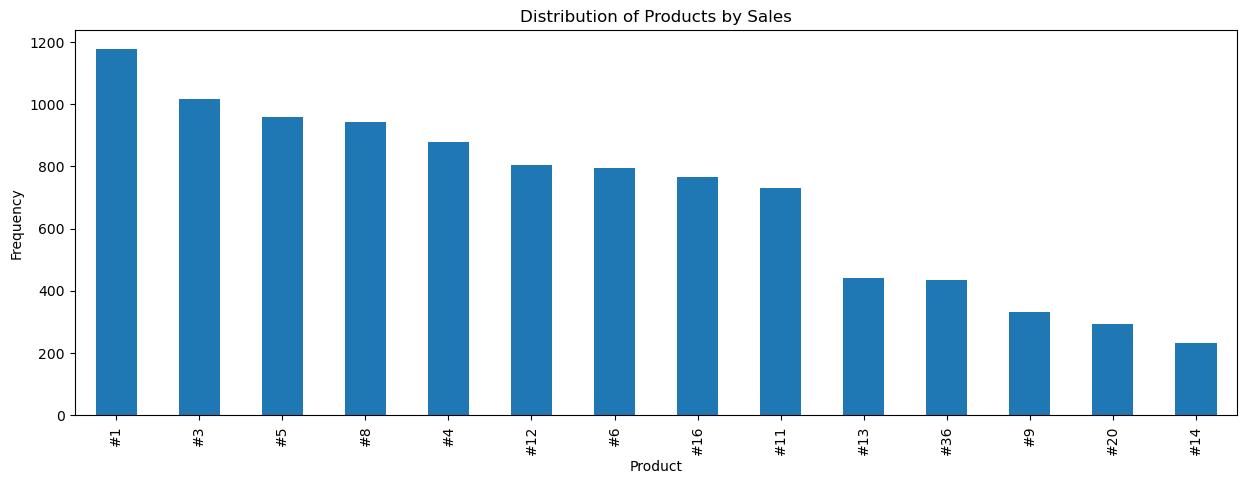

In [189]:
# plot the distribution of the products by sales
plt.figure(figsize=(15, 5))
sales_data['Mapped_GCK'].value_counts().plot(kind='bar')
plt.xlabel('Product')
plt.ylabel('Frequency')
plt.title('Distribution of Products by Sales')
plt.show()

### Sales revenue

* The total revenue is 2673845300.67 EUR.
* The dataset is highly imbalanced in terms of sales, with the top 3 products accounting for 93.77% of the total revenue.


In [190]:
# Check total revenue per product
sales_data.groupby('Mapped_GCK')['Sales_EUR'].sum()

Mapped_GCK
#1     1.544206e+09
#11    6.590131e+07
#12    8.279486e+06
#13    1.009157e+06
#14    4.938221e+05
#16    1.839118e+07
#20    7.832686e+04
#3     5.334435e+08
#36    9.986139e+05
#4     1.562720e+07
#5     4.295952e+08
#6     2.064189e+07
#8     3.487122e+07
#9     3.084465e+05
Name: Sales_EUR, dtype: float64

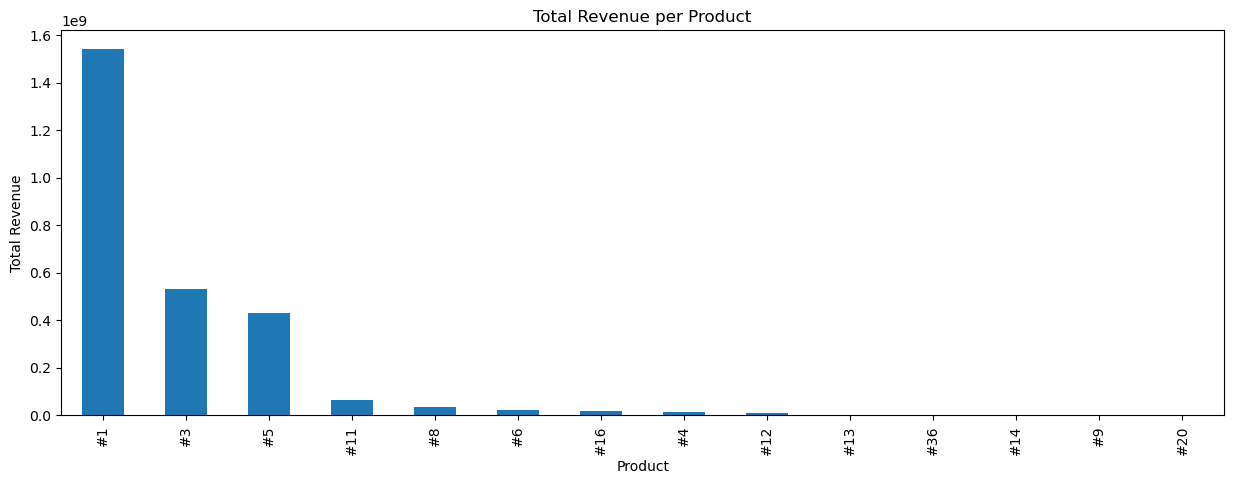

In [191]:
# Make a bar plot of total revenue per product
plt.figure(figsize=(15, 5))
(sales_data.groupby('Mapped_GCK')['Sales_EUR'].sum()
 .sort_values(ascending=False)
 .plot(kind='bar')
)
plt.xlabel('Product')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Product')
plt.show()

In [192]:
# Verify what is the percetange of the total revenue generated by the top 3 products
top3_revenue = sales_data.groupby('Mapped_GCK')['Sales_EUR'].sum().sort_values(ascending=False).head(3).sum()
total_revenue = sales_data['Sales_EUR'].sum()
top3_revenue_percent = (top3_revenue / total_revenue) * 100
print(f'The total revenue is {total_revenue:.2f} EUR.')
print(f'The top 3 products account for {top3_revenue_percent:.2f}% of the total revenue.')

The total revenue is 2673845300.67 EUR.
The top 3 products account for 93.77% of the total revenue.


## Seasonal effects
 
The data points to notable month-to-month and year-to-year fluctuations in both sales volume and revenue. In terms of monthly performance, **March records the highest number of sales at 969**, generating 264,695,388.51 EUR in revenue, while **May sees the lowest sales volume at 666**, bringing in 181,965,399.97 EUR. On average, monthly sales frequency stands at 816.83, with mean monthly revenue at 222,820,441.72 EUR.

Annually, **2020 leads in overall sales frequency** at 2,779, whereas **2021 posts the highest revenue** at 773,208,458.97 EUR. In contrast, 2018 lags behind with the fewest total sales (639) and the smallest revenue (141,544,018.09 EUR). Across all years, the average annual revenue is 534,769,060.13 EUR.

These patterns underline the importance of monitoring demand cycles—both seasonally and annually—to inform production planning, inventory management, and overall business strategy.

`Volume of sales by month`

>Sales drop during summer

The month with the highest frequency of sales is 3, with 969 sales. <br>
The month with the lowest frequency of sales is 5, with 666 sales. <br>
The average frequency of sales per month is 816.83.

In [193]:
# Check the sales distribution per month
sales_data['Month'] = sales_data['DATE'].dt.month
sales_data['Month'].value_counts()

Month
3     969
10    932
11    925
1     900
2     872
4     859
12    823
9     740
7     733
6     693
8     690
5     666
Name: count, dtype: int64

In [194]:
print(f'The month with the highest frequency of sales is {sales_data["Month"].value_counts().idxmax()}, with {sales_data["Month"].value_counts().max()} sales.')
print(f'The month with the lowest frequency of sales is {sales_data["Month"].value_counts().idxmin()}, with {sales_data["Month"].value_counts().min()} sales.')
print(f'The average frequency of sales per month is {sales_data["Month"].value_counts().mean():.2f}.')

The month with the highest frequency of sales is 3, with 969 sales.
The month with the lowest frequency of sales is 5, with 666 sales.
The average frequency of sales per month is 816.83.


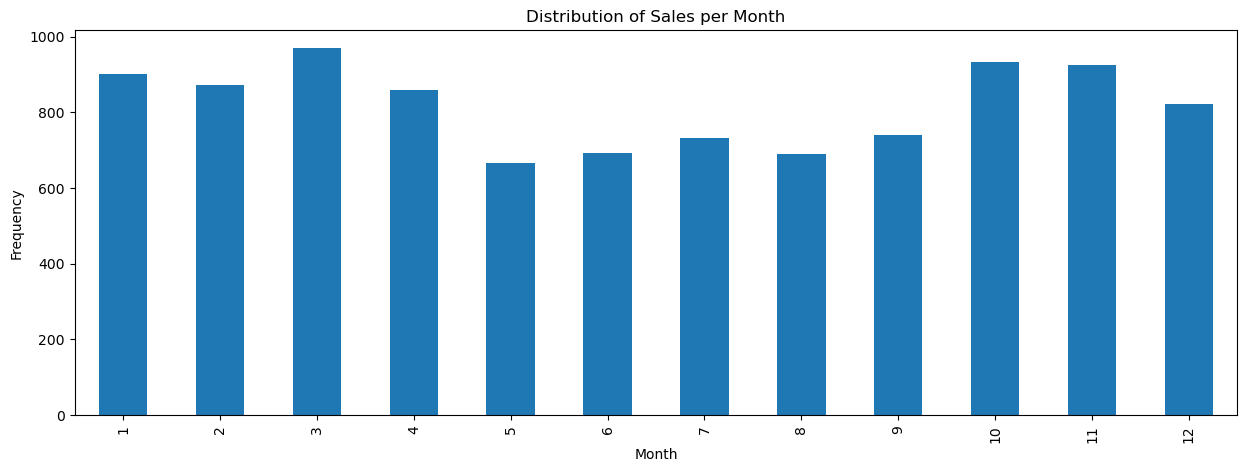

In [195]:
# plot the distribution of the sales per month
plt.figure(figsize=(15, 5))
sales_data['Month'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Sales per Month')
plt.show()

`Volume of sales by year`

The year with the highest frequency of sales is 2020, with 2779 sales.<br>
The year with the lowest frequency of sales is 2018, with 639 sales. <br>
The average frequency of sales per year is 1960.40.

In [196]:
# Check the sales distribution per year
sales_data['Year'] = sales_data['DATE'].dt.year
sales_data['Year'].value_counts()

Year
2020    2779
2021    2762
2019    2727
2022     895
2018     639
Name: count, dtype: int64

In [197]:
print(f'The year with the highest frequency of sales is {sales_data["Year"].value_counts().idxmax()}, with {sales_data["Year"].value_counts().max()} sales.')
print(f'The year with the lowest frequency of sales is {sales_data["Year"].value_counts().idxmin()}, with {sales_data["Year"].value_counts().min()} sales.')
print(f'The average frequency of sales per year is {sales_data["Year"].value_counts().mean():.2f}.')

The year with the highest frequency of sales is 2020, with 2779 sales.
The year with the lowest frequency of sales is 2018, with 639 sales.
The average frequency of sales per year is 1960.40.


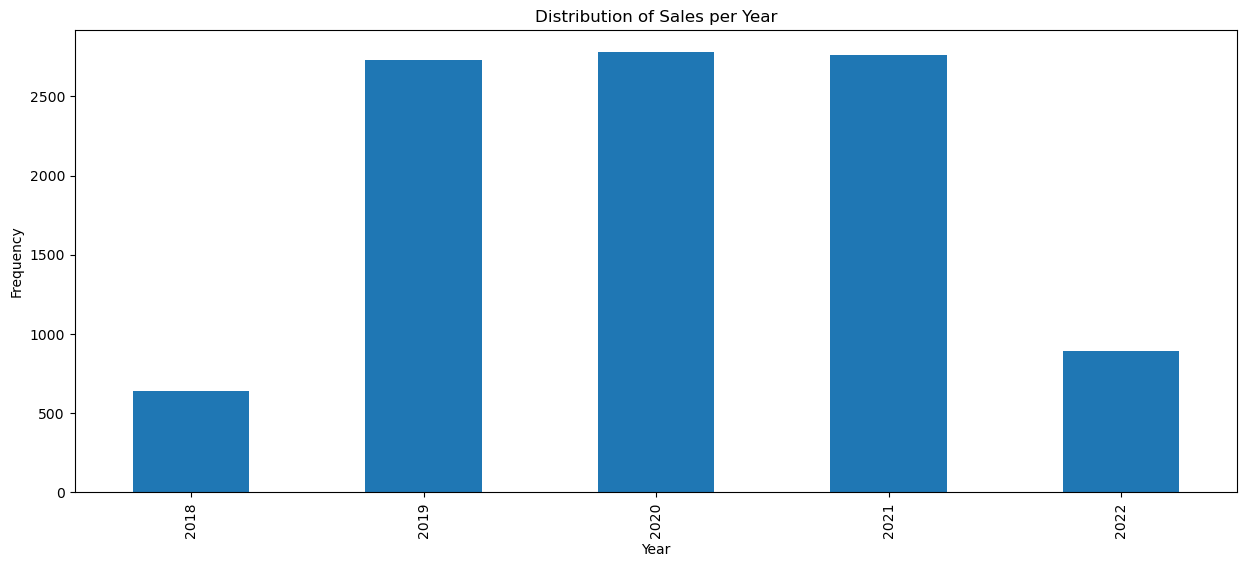

In [198]:
# plot the distribution of the sales per year
plt.figure(figsize=(15, 6))
sales_data['Year'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Sales per Year')
plt.show()

`Revenue by month`

>Revenue drops during summer.

The month with the highest revenue is 3, with 264695388.51 EUR. <br>
The month with the lowest revenue is 5, with 181965399.97 EUR. <br>
The average revenue per month is 222820441.72 EUR.

In [199]:
# check the revenue distribution per month
sales_data.groupby('Month')['Sales_EUR'].sum()

Month
1     2.015908e+08
2     2.489456e+08
3     2.646954e+08
4     2.522677e+08
5     1.819654e+08
6     1.957660e+08
7     1.864803e+08
8     1.990859e+08
9     2.302356e+08
10    2.422654e+08
11    2.253574e+08
12    2.451900e+08
Name: Sales_EUR, dtype: float64

In [200]:
print(f'The month with the highest revenue is {sales_data.groupby("Month")["Sales_EUR"].sum().idxmax()}, with {sales_data.groupby("Month")["Sales_EUR"].sum().max():.2f} EUR.')
print(f'The month with the lowest revenue is {sales_data.groupby("Month")["Sales_EUR"].sum().idxmin()}, with {sales_data.groupby("Month")["Sales_EUR"].sum().min():.2f} EUR.')
print(f'The average revenue per month is {sales_data.groupby("Month")["Sales_EUR"].sum().mean():.2f} EUR.')

The month with the highest revenue is 3, with 264695388.51 EUR.
The month with the lowest revenue is 5, with 181965399.97 EUR.
The average revenue per month is 222820441.72 EUR.


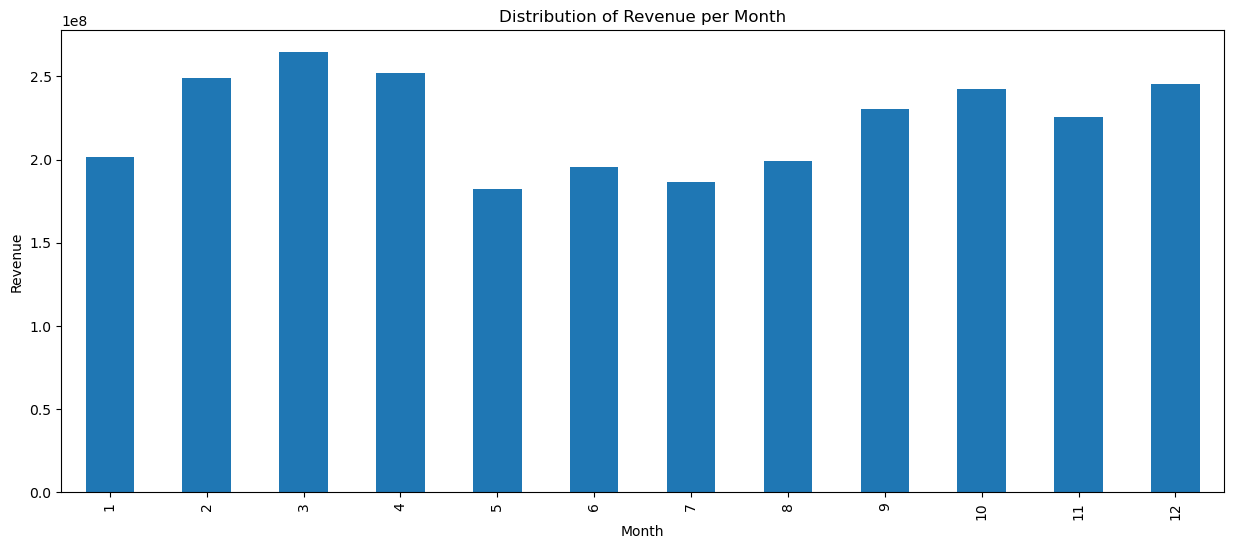

In [201]:
# plot the distribution of the revenue per month
plt.figure(figsize=(15, 6))
sales_data.groupby('Month')['Sales_EUR'].sum().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Distribution of Revenue per Month')
plt.show()

`Revenue by year`

The year with the highest revenue is 2021, with 773208458.97 EUR. <br>
The year with the lowest revenue is 2018, with 141544018.09 EUR. <br>
The average revenue per year is 534769060.13 EUR.

In [202]:
# check the revenue distribution per year
sales_data.groupby('Year')['Sales_EUR'].sum()

Year
2018    1.415440e+08
2019    7.564883e+08
2020    7.372189e+08
2021    7.732085e+08
2022    2.653857e+08
Name: Sales_EUR, dtype: float64

In [203]:
print(f'The year with the highest revenue is {sales_data.groupby("Year")["Sales_EUR"].sum().idxmax()}, with {sales_data.groupby("Year")["Sales_EUR"].sum().max():.2f} EUR.')
print(f'The year with the lowest revenue is {sales_data.groupby("Year")["Sales_EUR"].sum().idxmin()}, with {sales_data.groupby("Year")["Sales_EUR"].sum().min():.2f} EUR.')
print(f'The average revenue per year is {sales_data.groupby("Year")["Sales_EUR"].sum().mean():.2f} EUR.')

The year with the highest revenue is 2021, with 773208458.97 EUR.
The year with the lowest revenue is 2018, with 141544018.09 EUR.
The average revenue per year is 534769060.13 EUR.


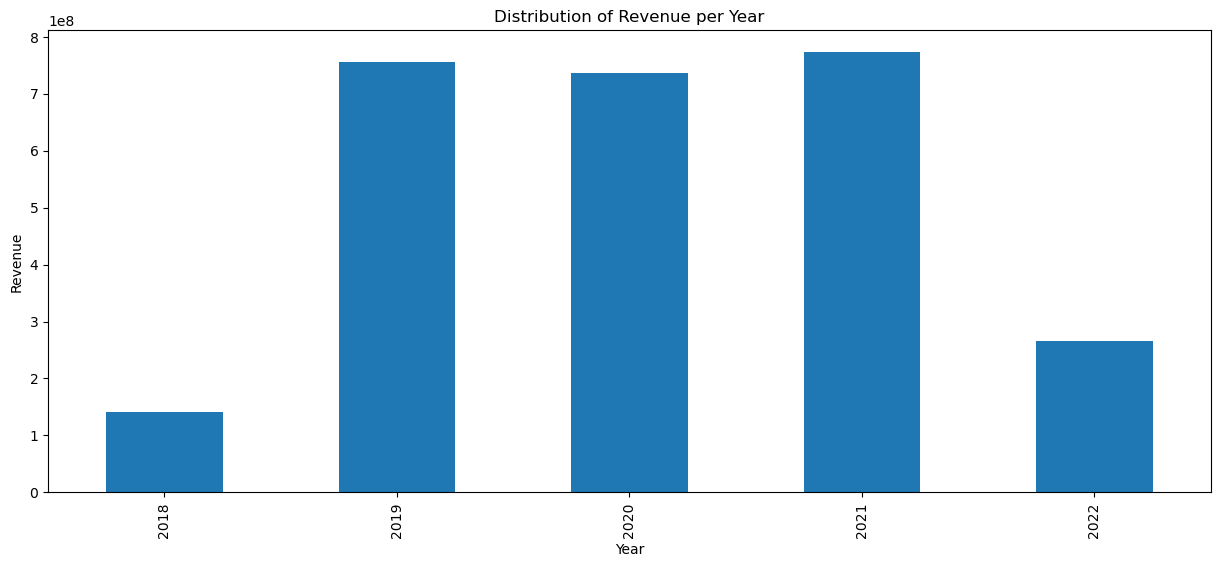

In [204]:
# plot the distribution of the revenue per year
plt.figure(figsize=(15, 6))
sales_data.groupby('Year')['Sales_EUR'].sum().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Distribution of Revenue per Year')
plt.show()

## Anomalies in sales data

* Sales_EUR has 7 missing values
* There are a total of 272 rows with negative sales. The product with the highest number of negative sales is product #3, with 56 negative sales, followed closely by product
* The three products with the most negative sales are: Product #3 with 56 negative sales, followed by Product #1 with 48 negative sales, and Product #5 with 43 negative sales.

In [205]:
sales_data.describe()

,DATE,Sales_EUR,Month,Year
count,9802,9.795000e+03,9802.000000,9802.000000
mean,2020-07-19 17:55:48.785961984,2.729806e+05,6.443277,2020.055805
min,2018-10-01 00:00:00,-5.063812e+05,1.000000,2018.000000
25%,2019-08-30 00:00:00,0.000000e+00,3.000000,2019.000000
50%,2020-07-26 12:00:00,0.000000e+00,6.000000,2020.000000
75%,2021-06-09 00:00:00,0.000000e+00,10.000000,2021.000000
max,2022-04-30 00:00:00,4.112799e+07,12.000000,2022.000000
std,NaN,2.231574e+06,3.573631,1.087653


In [206]:
# check the number of missing values
sales_data.isnull().sum()

DATE          0
Mapped_GCK    0
Sales_EUR     7
Month         0
Year          0
dtype: int64

In [207]:
# check missing values
sales_data[sales_data['Sales_EUR'].isnull()]

,DATE,Mapped_GCK,Sales_EUR,Month,Year
891,2020-05-06,#6,NaN,5,2020
2267,2019-10-02,#1,NaN,10,2019
2537,2019-12-06,#1,NaN,12,2019
3338,2020-04-06,#1,NaN,4,2020
3552,2020-05-07,#1,NaN,5,2020
3705,2020-06-05,#1,NaN,6,2020
8010,2019-10-02,#8,NaN,10,2019


In [208]:
# Check number of negative values per column
sales_data[sales_data['Sales_EUR'] < 0].count()

DATE          272
Mapped_GCK    272
Sales_EUR     272
Month         272
Year          272
dtype: int64

In [209]:
negative_values = sales_data[sales_data['Sales_EUR'] < 0]
negative_values.sample(15)

,DATE,Mapped_GCK,Sales_EUR,Month,Year
9244,2019-01-03,#4,-261.60,1,2019
3303,2020-04-02,#1,-5967.41,4,2020
2684,2022-02-02,#4,-99.36,2,2022
8619,2020-05-28,#36,-426.40,5,2020
7870,2021-07-02,#4,-1513.09,7,2021
3676,2020-06-03,#1,-35715.91,6,2020
130,2022-03-02,#6,-93.88,3,2022
2819,2021-10-04,#5,-25159.12,10,2021
894,2020-04-21,#4,-67499.20,4,2020
3002,2020-10-06,#4,-127.40,10,2020


In [210]:
# check number of negatives sales per product
negative_values['Mapped_GCK'].value_counts()

Mapped_GCK
#3     56
#1     48
#5     43
#4     40
#8     19
#9     11
#12    10
#6      9
#36     8
#11     7
#14     7
#16     6
#20     5
#13     3
Name: count, dtype: int64

In [211]:
print(f'The product with the highest number of negative sales is product {negative_values["Mapped_GCK"].value_counts().idxmax()}, with {negative_values["Mapped_GCK"].value_counts().max()} negative sales, followed close by product {negative_values["Mapped_GCK"].value_counts().idxmin()}, with {negative_values["Mapped_GCK"].value_counts().min()} negative sales.')

The product with the highest number of negative sales is product #3, with 56 negative sales, followed close by product #13, with 3 negative sales.


In [212]:
top_negative_sales = negative_values["Mapped_GCK"].value_counts().nlargest(3)

print(f'The three products with the most negative sales are: '
      f'Product {top_negative_sales.index[0]} with {top_negative_sales.iloc[0]} negative sales, followed by '
      f'Product {top_negative_sales.index[1]} with {top_negative_sales.iloc[1]} negative sales, '
      f'and Product {top_negative_sales.index[2]} with {top_negative_sales.iloc[2]} negative sales.')

The three products with the most negative sales are: Product #3 with 56 negative sales, followed by Product #1 with 48 negative sales, and Product #5 with 43 negative sales.


In [213]:
# Check for Sales_EUR = 0
zero_sales = sales_data[sales_data['Sales_EUR'] == 0]
zero_sales.count()

DATE          7134
Mapped_GCK    7134
Sales_EUR     7134
Month         7134
Year          7134
dtype: int64

In [214]:
# check number of zero sales per product
zero_sales['Mapped_GCK'].value_counts()

Mapped_GCK
#1     874
#3     752
#8     720
#5     700
#4     643
#12    628
#6     599
#11    580
#16    444
#13    300
#36    298
#9     228
#20    207
#14    161
Name: count, dtype: int64

## Make DATE the index

In [215]:
# Make date the index
sales_data.set_index('DATE', inplace=True)

In [216]:
sales_data.head(15)

,Mapped_GCK,Sales_EUR,Month,Year
DATE,,,,
2018-10-01,#1,0.0,10,2018
2018-10-02,#1,0.0,10,2018
2018-10-03,#1,0.0,10,2018
2018-10-04,#1,0.0,10,2018
2018-10-05,#1,0.0,10,2018
2018-10-06,#1,0.0,10,2018
2018-10-08,#1,0.0,10,2018
2018-10-09,#1,0.0,10,2018
2018-10-10,#1,0.0,10,2018


In [217]:
# sort the data by the index
sales_data.sort_index(inplace=True)

## Identify major drivers for demand for the product groups

We will analyse the Market data provided, to check if there are outsider factors influencing demand for SIEMENS products.

In [218]:
# Import xlsx dataset into pandas dataframe
market_data = pd.read_excel('/Users/diogocarvalho/Documents/GitHub/Case-2--Siemens-Sales-Forecast/Data/Case2_Market data.xlsx', header=[0,1,2])

In [219]:
# First impression on the market data
print(f'The dataset has {market_data.shape[0]} rows and {market_data.shape[1]} columns.')
market_data.head()

The dataset has 219 rows and 48 columns.


Unnamed: 0_level_0  \
  Index 2010=100 (if not otherwise noted)   
                                     date   
0                                  2004m2   
1                                  2004m3   
2                                  2004m4   
3                                  2004m5   
4                                  2004m6   

                                     China  \
  Production Index Machinery & Electricals   
                            MAB_ELE_PRO156   
0                                16.940704   
1                                23.711852   
2                                24.435235   
3                                23.708115   
4                                27.009138   

                                           \
  Shipments Index Machinery & Electricals   
                           MAB_ELE_SHP156   
0                               16.940704   
1                               23.711852   
2                               24.435235   
3                               23.708115   
4                               27.009138   

                                    France  \
  Production Index Machinery & Electricals   
                            MAB_ELE_PRO250   
0                               112.091273   
1                               136.327976   
2                               117.791806   
3                               109.002541   
4                               133.785737   

                                           \
  Shipments Index Machinery & Electricals   
                           MAB_ELE_SHP250   
0                               83.458866   
1                              106.168192   
2                               92.007646   
3                               85.696486   
4                              106.641482   

                                   Germany  \
  Production Index Machinery & Electricals   
                            MAB_ELE_PRO276   
0                                82.623037   
1                               100.556582   
2                                89.653203   
3                                86.880571   
4                                99.010814   

                                           \
  Shipments Index Machinery & Electricals   
                           MAB_ELE_SHP276   
0                               79.452532   
1                               97.012918   
2                               84.932358   
3                               82.372794   
4                               95.108740   

                                     Italy  \
  Production Index Machinery & Electricals   
                            MAB_ELE_PRO380   
0                               124.289603   
1                               143.411662   
2                               129.083828   
3                               135.590391   
4                               136.424935   

                                           \
  Shipments Index Machinery & Electricals   
                           MAB_ELE_SHP380   
0                               86.560493   
1                              106.344544   
2                               95.579673   
3                              100.087039   
4                              110.889719   

                                     Japan  \
  Production Index Machinery & Electricals   
                            MAB_ELE_PRO392   
0                               109.334010   
1                               140.884616   
2                               105.853579   
3                               101.864777   
4                               120.332920   

                                           \
  Shipments Index Machinery & Electricals   
                           MAB_ELE_SHP392   
0                              110.495272   
1                              144.686166   
2                              102.655769   
3                              100.305285   
4                              119.616380   

            

In [220]:
# drop the second header row
market_data.columns = market_data.columns.droplevel(1)

In [221]:
market_data.head()

Unnamed: 0_level_0          China                        France  \
                date MAB_ELE_PRO156 MAB_ELE_SHP156 MAB_ELE_PRO250   
0             2004m2      16.940704      16.940704     112.091273   
1             2004m3      23.711852      23.711852     136.327976   
2             2004m4      24.435235      24.435235     117.791806   
3             2004m5      23.708115      23.708115     109.002541   
4             2004m6      27.009138      27.009138     133.785737   

                        Germany                         Italy                 \
  MAB_ELE_SHP250 MAB_ELE_PRO276 MAB_ELE_SHP276 MAB_ELE_PRO380 MAB_ELE_SHP380   
0      83.458866      82.623037      79.452532     124.289603      86.560493   
1     106.168192     100.556582      97.012918     143.411662     106.344544   
2      92.007646      89.653203      84.932358     129.083828      95.579673   
3      85.696486      86.880571      82.372794     135.590391     100.087039   
4     106.641482      99.010814      95.108740     136.424935     110.889719   

           Japan                   Switzerland                United Kingdom  \
  MAB_ELE_PRO392 MAB_ELE_SHP392 MAB_ELE_PRO756 MAB_ELE_SHP756 MAB_ELE_PRO826   
0     109.334010     110.495272      91.221862      89.987275     111.353812   
1     140.884616     144.686166      85.866287      79.883583     127.558608   
2     105.853579     102.655769      85.622508      79.740802     108.732297   
3     101.864777     100.305285      85.378729      79.598021     110.645200   
4     120.332920     119.616380      85.134950      79.455239     122.020960   

                  United States                         Europe  \
  MAB_ELE_SHP826 MAB_ELE_PRO840 MAB_ELE_SHP840 MAB_ELE_PRO1100   
0      73.601265     107.601400      79.240230       97.122911   
1      84.047595     110.187364      98.619024      113.783904   
2      73.026027     108.166564      89.774031      101.715199   
3      74.591883     108.425887      87.463813      101.275727   
4      82.343346     110.569933      97.364496      112.057197   

                                                                             \
  MAB_ELE_SHP1100 RohiBASEMET1000_org RohiENERGY1000_org RohiMETMIN1000_org   
0       80.098530           54.039811          44.123338          48.747945   
1       96.015929           54.666162          47.588957          49.256157   
2       85.167236           54.872715          47.779013          49.423751   
3       84.485767           51.230356          53.590898          46.468392   
4       96.963294           52.876331          50.799575          47.803913   

                                                                              \
  RohiNATGAS1000_org RohCRUDE_PETRO1000_org RohCOPPER1000_org WKLWEUR840_org   
0          87.076974              39.639458         36.623832         1.2646   
1          87.192705              42.592034         39.931055         1.2262   
2          91.379923              42.650637         39.134854         1.1985   
3          99.044520              47.517121         36.278433         1.2007   
4          98.636267              44.967605         35.657380         1.2138   

  Producer Prices                                                      \
     PRI27840_org PRI27826_org PRI27380_org PRI27250_org PRI27276_org   
0       78.969864    80.757423    93.020027          NaN    93.230453   
1       79.673569    80.962135    93.540268          NaN    93.335678   
2       80.337639    80.757423    93.852425          NaN    93.440903   
3       80.798828    80.757423    93.852425          NaN    93.546127   
4       80.913490    80.552711    93.956467          NaN    93.440903   

               production index                                          \
  PRI27156_org     PRO28840_org PRO281000_org PRO28756_org PRO28826_org   
0          NaN       102.491722     97.597374    97.100000   106.191977   
1          NaN       105.627480    113.224892    91.195116   121.625075   
2     

In [222]:
# Join the header levels
market_data.columns = [
    '_'.join([str(level) for level in col_tuple]).strip()
    for col_tuple in market_data.columns
]


In [223]:
market_data.head()

,Unnamed: 0_level_0_date,China_MAB_ELE_PRO156,China_MAB_ELE_SHP156,France_MAB_ELE_PRO250,France_MAB_ELE_SHP250,Germany_MAB_ELE_PRO276,Germany_MAB_ELE_SHP276,Italy_MAB_ELE_PRO380,Italy_MAB_ELE_SHP380,Japan_MAB_ELE_PRO392,Japan_MAB_ELE_SHP392,Switzerland_MAB_ELE_PRO756,Switzerland_MAB_ELE_SHP756,United Kingdom_MAB_ELE_PRO826,United Kingdom_MAB_ELE_SHP826,United States_MAB_ELE_PRO840,United States_MAB_ELE_SHP840,Europe_MAB_ELE_PRO1100,Europe_MAB_ELE_SHP1100,Europe_RohiBASEMET1000_org,Europe_RohiENERGY1000_org,Europe_RohiMETMIN1000_org,Europe_RohiNATGAS1000_org,Europe_RohCRUDE_PETRO1000_org,Europe_RohCOPPER1000_org,Europe_WKLWEUR840_org,Producer Prices_PRI27840_org,Producer Prices_PRI27826_org,Producer Prices_PRI27380_org,Producer Prices_PRI27250_org,Producer Prices_PRI27276_org,Producer Prices_PRI27156_org,production index_PRO28840_org,production index_PRO281000_org,production index_PRO28756_org,production index_PRO28826_org,production index_PRO28380_org,production index_PRO28392_org,production index_PRO28250_org,production index_PRO28276_org,production index_PRO27840_org,production index_PRO271000_org,production index_PRO27756_org,production index_PRO27826_org,production index_PRO27380_org,production index_PRO27392_org,production index_PRO27250_org,production index_PRO27276_org
0,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.334010,110.495272,91.221862,89.987275,111.353812,73.601265,107.601400,79.240230,97.122911,80.098530,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.100000,106.191977,116.790276,110.890034,118.274109,80.829010,117.723991,NaN,81.100000,120.706516,141.510864,106.161262,102.077057,85.913200
1,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.627480,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.309550,152.880234,140.288741,117.225685,97.670815
2,2004m4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236,54.872715,47.779013,49.423751,91.379923,42.650637,39.134854,1.1985,80.337639,80.757423,93.852425,NaN,93.440903,NaN,103.484955,100.169090,93.793535,104.965505,125.289566,105.648765,125.482231,90.961426,117.441124,NaN,71.552403,115.557330,137.796875,106.271197,105.335777,87.253983
3,2004m5,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.645200,74.591883,108.425887,87.463813,101.275727,84.485767,51.230356,53.590898,46.468392,99.044520,47.517121,36.278433,1.2007,80.798828,80.757423,93.852425,NaN,93.546127,NaN,103.643944,99.581436,96.391954,105.885359,131.988998,101.990361,116.649750,88.082901,117.899216,NaN,66.414500,119.269534,143.860535,101.608710,96.616508,84.675552
4,2004m6,27.009138,27.009138,133.785737,106.641482,99.010814,95.108740,136.424935,110.889719,120.332920,119.616380,85.134950,79.455239,122.020960,82.343346,110.569933,97.364496,112.057197,96.963294,52.876331,50.799575,47.803913,98.636267,44.967605,35.657380,1.2138,80.913490,80.552711,93.956467,NaN,93.440903,NaN,106.062668,109.277710,98.990373,118.252278,132.988922,122.136575,143.248734,100.978699,119.499107,NaN,61.276596,128.849416,144.315308,116.655248,118.458710,95.401802


In [224]:
market_data.columns

Index(['Unnamed: 0_level_0_date', 'China_MAB_ELE_PRO156',
       'China_MAB_ELE_SHP156', 'France_MAB_ELE_PRO250',
       'France_MAB_ELE_SHP250', 'Germany_MAB_ELE_PRO276',
       'Germany_MAB_ELE_SHP276', 'Italy_MAB_ELE_PRO380',
       'Italy_MAB_ELE_SHP380', 'Japan_MAB_ELE_PRO392', 'Japan_MAB_ELE_SHP392',
       'Switzerland_MAB_ELE_PRO756', 'Switzerland_MAB_ELE_SHP756',
       'United Kingdom_MAB_ELE_PRO826', 'United Kingdom_MAB_ELE_SHP826',
       'United States_MAB_ELE_PRO840', 'United States_MAB_ELE_SHP840',
       'Europe_MAB_ELE_PRO1100', 'Europe_MAB_ELE_SHP1100',
       'Europe_RohiBASEMET1000_org', 'Europe_RohiENERGY1000_org',
       'Europe_RohiMETMIN1000_org', 'Europe_RohiNATGAS1000_org',
       'Europe_RohCRUDE_PETRO1000_org', 'Europe_RohCOPPER1000_org',
       'Europe_WKLWEUR840_org', 'Producer Prices_PRI27840_org',
       'Producer Prices_PRI27826_org', 'Producer Prices_PRI27380_org',
       'Producer Prices_PRI27250_org', 'Producer Prices_PRI27276_org',
       'Producer 

In [225]:
# change first column name to "Date"

market_data.rename(columns={'Unnamed: 0_level_0_date': 'DATE'}, inplace=True)

In [226]:
# Verify changes
market_data.head()

,DATE,China_MAB_ELE_PRO156,China_MAB_ELE_SHP156,France_MAB_ELE_PRO250,France_MAB_ELE_SHP250,Germany_MAB_ELE_PRO276,Germany_MAB_ELE_SHP276,Italy_MAB_ELE_PRO380,Italy_MAB_ELE_SHP380,Japan_MAB_ELE_PRO392,Japan_MAB_ELE_SHP392,Switzerland_MAB_ELE_PRO756,Switzerland_MAB_ELE_SHP756,United Kingdom_MAB_ELE_PRO826,United Kingdom_MAB_ELE_SHP826,United States_MAB_ELE_PRO840,United States_MAB_ELE_SHP840,Europe_MAB_ELE_PRO1100,Europe_MAB_ELE_SHP1100,Europe_RohiBASEMET1000_org,Europe_RohiENERGY1000_org,Europe_RohiMETMIN1000_org,Europe_RohiNATGAS1000_org,Europe_RohCRUDE_PETRO1000_org,Europe_RohCOPPER1000_org,Europe_WKLWEUR840_org,Producer Prices_PRI27840_org,Producer Prices_PRI27826_org,Producer Prices_PRI27380_org,Producer Prices_PRI27250_org,Producer Prices_PRI27276_org,Producer Prices_PRI27156_org,production index_PRO28840_org,production index_PRO281000_org,production index_PRO28756_org,production index_PRO28826_org,production index_PRO28380_org,production index_PRO28392_org,production index_PRO28250_org,production index_PRO28276_org,production index_PRO27840_org,production index_PRO271000_org,production index_PRO27756_org,production index_PRO27826_org,production index_PRO27380_org,production index_PRO27392_org,production index_PRO27250_org,production index_PRO27276_org
0,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.334010,110.495272,91.221862,89.987275,111.353812,73.601265,107.601400,79.240230,97.122911,80.098530,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.100000,106.191977,116.790276,110.890034,118.274109,80.829010,117.723991,NaN,81.100000,120.706516,141.510864,106.161262,102.077057,85.913200
1,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.627480,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.309550,152.880234,140.288741,117.225685,97.670815
2,2004m4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236,54.872715,47.779013,49.423751,91.379923,42.650637,39.134854,1.1985,80.337639,80.757423,93.852425,NaN,93.440903,NaN,103.484955,100.169090,93.793535,104.965505,125.289566,105.648765,125.482231,90.961426,117.441124,NaN,71.552403,115.557330,137.796875,106.271197,105.335777,87.253983
3,2004m5,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.645200,74.591883,108.425887,87.463813,101.275727,84.485767,51.230356,53.590898,46.468392,99.044520,47.517121,36.278433,1.2007,80.798828,80.757423,93.852425,NaN,93.546127,NaN,103.643944,99.581436,96.391954,105.885359,131.988998,101.990361,116.649750,88.082901,117.899216,NaN,66.414500,119.269534,143.860535,101.608710,96.616508,84.675552
4,2004m6,27.009138,27.009138,133.785737,106.641482,99.010814,95.108740,136.424935,110.889719,120.332920,119.616380,85.134950,79.455239,122.020960,82.343346,110.569933,97.364496,112.057197,96.963294,52.876331,50.799575,47.803913,98.636267,44.967605,35.657380,1.2138,80.913490,80.552711,93.956467,NaN,93.440903,NaN,106.062668,109.277710,98.990373,118.252278,132.988922,122.136575,143.248734,100.978699,119.499107,NaN,61.276596,128.849416,144.315308,116.655248,118.458710,95.401802


In [227]:
market_data['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 219 entries, 0 to 218
Series name: DATE
Non-Null Count  Dtype 
--------------  ----- 
219 non-null    object
dtypes: object(1)
memory usage: 1.8+ KB


In [228]:
# Convert the DATE column to datetime

# First change "m" to "-" 
market_data['DATE'] = market_data['DATE'].str.replace('m', '-')

In [229]:
# Verify changes
market_data.head()

,DATE,China_MAB_ELE_PRO156,China_MAB_ELE_SHP156,France_MAB_ELE_PRO250,France_MAB_ELE_SHP250,Germany_MAB_ELE_PRO276,Germany_MAB_ELE_SHP276,Italy_MAB_ELE_PRO380,Italy_MAB_ELE_SHP380,Japan_MAB_ELE_PRO392,Japan_MAB_ELE_SHP392,Switzerland_MAB_ELE_PRO756,Switzerland_MAB_ELE_SHP756,United Kingdom_MAB_ELE_PRO826,United Kingdom_MAB_ELE_SHP826,United States_MAB_ELE_PRO840,United States_MAB_ELE_SHP840,Europe_MAB_ELE_PRO1100,Europe_MAB_ELE_SHP1100,Europe_RohiBASEMET1000_org,Europe_RohiENERGY1000_org,Europe_RohiMETMIN1000_org,Europe_RohiNATGAS1000_org,Europe_RohCRUDE_PETRO1000_org,Europe_RohCOPPER1000_org,Europe_WKLWEUR840_org,Producer Prices_PRI27840_org,Producer Prices_PRI27826_org,Producer Prices_PRI27380_org,Producer Prices_PRI27250_org,Producer Prices_PRI27276_org,Producer Prices_PRI27156_org,production index_PRO28840_org,production index_PRO281000_org,production index_PRO28756_org,production index_PRO28826_org,production index_PRO28380_org,production index_PRO28392_org,production index_PRO28250_org,production index_PRO28276_org,production index_PRO27840_org,production index_PRO271000_org,production index_PRO27756_org,production index_PRO27826_org,production index_PRO27380_org,production index_PRO27392_org,production index_PRO27250_org,production index_PRO27276_org
0,2004-2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.334010,110.495272,91.221862,89.987275,111.353812,73.601265,107.601400,79.240230,97.122911,80.098530,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.100000,106.191977,116.790276,110.890034,118.274109,80.829010,117.723991,NaN,81.100000,120.706516,141.510864,106.161262,102.077057,85.913200
1,2004-3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.627480,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.309550,152.880234,140.288741,117.225685,97.670815
2,2004-4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236,54.872715,47.779013,49.423751,91.379923,42.650637,39.134854,1.1985,80.337639,80.757423,93.852425,NaN,93.440903,NaN,103.484955,100.169090,93.793535,104.965505,125.289566,105.648765,125.482231,90.961426,117.441124,NaN,71.552403,115.557330,137.796875,106.271197,105.335777,87.253983
3,2004-5,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.645200,74.591883,108.425887,87.463813,101.275727,84.485767,51.230356,53.590898,46.468392,99.044520,47.517121,36.278433,1.2007,80.798828,80.757423,93.852425,NaN,93.546127,NaN,103.643944,99.581436,96.391954,105.885359,131.988998,101.990361,116.649750,88.082901,117.899216,NaN,66.414500,119.269534,143.860535,101.608710,96.616508,84.675552
4,2004-6,27.009138,27.009138,133.785737,106.641482,99.010814,95.108740,136.424935,110.889719,120.332920,119.616380,85.134950,79.455239,122.020960,82.343346,110.569933,97.364496,112.057197,96.963294,52.876331,50.799575,47.803913,98.636267,44.967605,35.657380,1.2138,80.913490,80.552711,93.956467,NaN,93.440903,NaN,106.062668,109.277710,98.990373,118.252278,132.988922,122.136575,143.248734,100.978699,119.499107,NaN,61.276596,128.849416,144.315308,116.655248,118.458710,95.401802


In [230]:
# Convert DATE column to datetime
market_data['DATE'] = pd.to_datetime(market_data['DATE'], format='mixed')

In [231]:
# Verify changes
market_data.head()

,DATE,China_MAB_ELE_PRO156,China_MAB_ELE_SHP156,France_MAB_ELE_PRO250,France_MAB_ELE_SHP250,Germany_MAB_ELE_PRO276,Germany_MAB_ELE_SHP276,Italy_MAB_ELE_PRO380,Italy_MAB_ELE_SHP380,Japan_MAB_ELE_PRO392,Japan_MAB_ELE_SHP392,Switzerland_MAB_ELE_PRO756,Switzerland_MAB_ELE_SHP756,United Kingdom_MAB_ELE_PRO826,United Kingdom_MAB_ELE_SHP826,United States_MAB_ELE_PRO840,United States_MAB_ELE_SHP840,Europe_MAB_ELE_PRO1100,Europe_MAB_ELE_SHP1100,Europe_RohiBASEMET1000_org,Europe_RohiENERGY1000_org,Europe_RohiMETMIN1000_org,Europe_RohiNATGAS1000_org,Europe_RohCRUDE_PETRO1000_org,Europe_RohCOPPER1000_org,Europe_WKLWEUR840_org,Producer Prices_PRI27840_org,Producer Prices_PRI27826_org,Producer Prices_PRI27380_org,Producer Prices_PRI27250_org,Producer Prices_PRI27276_org,Producer Prices_PRI27156_org,production index_PRO28840_org,production index_PRO281000_org,production index_PRO28756_org,production index_PRO28826_org,production index_PRO28380_org,production index_PRO28392_org,production index_PRO28250_org,production index_PRO28276_org,production index_PRO27840_org,production index_PRO271000_org,production index_PRO27756_org,production index_PRO27826_org,production index_PRO27380_org,production index_PRO27392_org,production index_PRO27250_org,production index_PRO27276_org
0,2004-02-01,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.334010,110.495272,91.221862,89.987275,111.353812,73.601265,107.601400,79.240230,97.122911,80.098530,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.100000,106.191977,116.790276,110.890034,118.274109,80.829010,117.723991,NaN,81.100000,120.706516,141.510864,106.161262,102.077057,85.913200
1,2004-03-01,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.627480,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.309550,152.880234,140.288741,117.225685,97.670815
2,2004-04-01,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236,54.872715,47.779013,49.423751,91.379923,42.650637,39.134854,1.1985,80.337639,80.757423,93.852425,NaN,93.440903,NaN,103.484955,100.169090,93.793535,104.965505,125.289566,105.648765,125.482231,90.961426,117.441124,NaN,71.552403,115.557330,137.796875,106.271197,105.335777,87.253983
3,2004-05-01,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.645200,74.591883,108.425887,87.463813,101.275727,84.485767,51.230356,53.590898,46.468392,99.044520,47.517121,36.278433,1.2007,80.798828,80.757423,93.852425,NaN,93.546127,NaN,103.643944,99.581436,96.391954,105.885359,131.988998,101.990361,116.649750,88.082901,117.899216,NaN,66.414500,119.269534,143.860535,101.608710,96.616508,84.675552
4,2004-06-01,27.009138,27.009138,133.785737,106.641482,99.010814,95.108740,136.424935,110.889719,120.332920,119.616380,85.134950,79.455239,122.020960,82.343346,110.569933,97.364496,112.057197,96.963294,52.876331,50.799575,47.803913,98.636267,44.967605,35.657380,1.2138,80.913490,80.552711,93.956467,NaN,93.440903,NaN,106.062668,109.277710,98.990373,118.252278,132.988922,122.136575,143.248734,100.978699,119.499107,NaN,61.276596,128.849416,144.315308,116.655248,118.458710,95.401802


In [232]:
# Make Date the index
market_data.set_index('DATE', inplace=True)

In [233]:
# Verify changes
market_data.head()

,China_MAB_ELE_PRO156,China_MAB_ELE_SHP156,France_MAB_ELE_PRO250,France_MAB_ELE_SHP250,Germany_MAB_ELE_PRO276,Germany_MAB_ELE_SHP276,Italy_MAB_ELE_PRO380,Italy_MAB_ELE_SHP380,Japan_MAB_ELE_PRO392,Japan_MAB_ELE_SHP392,Switzerland_MAB_ELE_PRO756,Switzerland_MAB_ELE_SHP756,United Kingdom_MAB_ELE_PRO826,United Kingdom_MAB_ELE_SHP826,United States_MAB_ELE_PRO840,United States_MAB_ELE_SHP840,Europe_MAB_ELE_PRO1100,Europe_MAB_ELE_SHP1100,Europe_RohiBASEMET1000_org,Europe_RohiENERGY1000_org,Europe_RohiMETMIN1000_org,Europe_RohiNATGAS1000_org,Europe_RohCRUDE_PETRO1000_org,Europe_RohCOPPER1000_org,Europe_WKLWEUR840_org,Producer Prices_PRI27840_org,Producer Prices_PRI27826_org,Producer Prices_PRI27380_org,Producer Prices_PRI27250_org,Producer Prices_PRI27276_org,Producer Prices_PRI27156_org,production index_PRO28840_org,production index_PRO281000_org,production index_PRO28756_org,production index_PRO28826_org,production index_PRO28380_org,production index_PRO28392_org,production index_PRO28250_org,production index_PRO28276_org,production index_PRO27840_org,production index_PRO271000_org,production index_PRO27756_org,production index_PRO27826_org,production index_PRO27380_org,production index_PRO27392_org,production index_PRO27250_org,production index_PRO27276_org
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-02-01,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.334010,110.495272,91.221862,89.987275,111.353812,73.601265,107.601400,79.240230,97.122911,80.098530,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.100000,106.191977,116.790276,110.890034,118.274109,80.829010,117.723991,NaN,81.100000,120.706516,141.510864,106.161262,102.077057,85.913200
2004-03-01,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.627480,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.309550,152.880234,140.288741,117.225685,97.670815
2004-04-01,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236,54.872715,47.779013,49.423751,91.379923,42.650637,39.134854,1.1985,80.337639,80.757423,93.852425,NaN,93.440903,NaN,103.484955,100.169090,93.793535,104.965505,125.289566,105.648765,125.482231,90.961426,117.441124,NaN,71.552403,115.557330,137.796875,106.271197,105.335777,87.253983
2004-05-01,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.645200,74.591883,108.425887,87.463813,101.275727,84.485767,51.230356,53.590898,46.468392,99.044520,47.517121,36.278433,1.2007,80.798828,80.757423,93.852425,NaN,93.546127,NaN,103.643944,99.581436,96.391954,105.885359,131.988998,101.990361,116.649750,88.082901,117.899216,NaN,66.414500,119.269534,143.860535,101.608710,96.616508,84.675552
2004-06-01,27.009138,27.009138,133.785737,106.641482,99.010814,95.108740,136.424935,110.889719,120.332920,119.616380,85.134950,79.455239,122.020960,82.343346,110.569933,97.364496,112.057197,96.963294,52.876331,50.799575,47.803913,98.636267,44.967605,35.657380,1.2138,80.913490,80.552711,93.956467,NaN,93.440903,NaN,106.062668,109.277710,98.990373,118.252278,132.988922,122.136575,143.248734,100.978699,119.499107,NaN,61.276596,128.849416,144.315308,116.655248,118.458710,95.401802


Columns from index 0-18 correspond to production and shipment indexes, interatively <br>
Columns from index 18-24 correspond to price of materials, so keep them in separate dataframe <br>
Columns from index 25-30 corresponde to producer prices <br>
Columns from index 30 onwards correspond to production index

In [234]:
market_data.columns

Index(['China_MAB_ELE_PRO156', 'China_MAB_ELE_SHP156', 'France_MAB_ELE_PRO250',
       'France_MAB_ELE_SHP250', 'Germany_MAB_ELE_PRO276',
       'Germany_MAB_ELE_SHP276', 'Italy_MAB_ELE_PRO380',
       'Italy_MAB_ELE_SHP380', 'Japan_MAB_ELE_PRO392', 'Japan_MAB_ELE_SHP392',
       'Switzerland_MAB_ELE_PRO756', 'Switzerland_MAB_ELE_SHP756',
       'United Kingdom_MAB_ELE_PRO826', 'United Kingdom_MAB_ELE_SHP826',
       'United States_MAB_ELE_PRO840', 'United States_MAB_ELE_SHP840',
       'Europe_MAB_ELE_PRO1100', 'Europe_MAB_ELE_SHP1100',
       'Europe_RohiBASEMET1000_org', 'Europe_RohiENERGY1000_org',
       'Europe_RohiMETMIN1000_org', 'Europe_RohiNATGAS1000_org',
       'Europe_RohCRUDE_PETRO1000_org', 'Europe_RohCOPPER1000_org',
       'Europe_WKLWEUR840_org', 'Producer Prices_PRI27840_org',
       'Producer Prices_PRI27826_org', 'Producer Prices_PRI27380_org',
       'Producer Prices_PRI27250_org', 'Producer Prices_PRI27276_org',
       'Producer Prices_PRI27156_org', 'production 

## ship_prod_indexes dataframe

In [235]:
# Slice dataframe and keep the first 20 columns
ship_prod_indexes = market_data.iloc[:, :18]

In [236]:
ship_prod_indexes.shape

(219, 18)

In [237]:
ship_prod_indexes.columns

Index(['China_MAB_ELE_PRO156', 'China_MAB_ELE_SHP156', 'France_MAB_ELE_PRO250',
       'France_MAB_ELE_SHP250', 'Germany_MAB_ELE_PRO276',
       'Germany_MAB_ELE_SHP276', 'Italy_MAB_ELE_PRO380',
       'Italy_MAB_ELE_SHP380', 'Japan_MAB_ELE_PRO392', 'Japan_MAB_ELE_SHP392',
       'Switzerland_MAB_ELE_PRO756', 'Switzerland_MAB_ELE_SHP756',
       'United Kingdom_MAB_ELE_PRO826', 'United Kingdom_MAB_ELE_SHP826',
       'United States_MAB_ELE_PRO840', 'United States_MAB_ELE_SHP840',
       'Europe_MAB_ELE_PRO1100', 'Europe_MAB_ELE_SHP1100'],
      dtype='object')

## materials_price dataframe

In [238]:
# Slice the dataframe and keep columns 18 to 24
materials_price = market_data.iloc[:, 18:25]

In [239]:
materials_price.columns

Index(['Europe_RohiBASEMET1000_org', 'Europe_RohiENERGY1000_org',
       'Europe_RohiMETMIN1000_org', 'Europe_RohiNATGAS1000_org',
       'Europe_RohCRUDE_PETRO1000_org', 'Europe_RohCOPPER1000_org',
       'Europe_WKLWEUR840_org'],
      dtype='object')

## producer_price dataframe

In [240]:
# Slice the dataframe and keep columns from 25 to 30
producer_price = market_data.iloc[:, 25:31]

In [241]:
producer_price.columns

Index(['Producer Prices_PRI27840_org', 'Producer Prices_PRI27826_org',
       'Producer Prices_PRI27380_org', 'Producer Prices_PRI27250_org',
       'Producer Prices_PRI27276_org', 'Producer Prices_PRI27156_org'],
      dtype='object')

## production_index dataframe

In [242]:
# Slice the dataframe and keep columns from 31 to the end
production_index = market_data.iloc[:, 31:]

In [243]:
production_index.columns

Index(['production index_PRO28840_org', 'production index_PRO281000_org',
       'production index_PRO28756_org', 'production index_PRO28826_org',
       'production index_PRO28380_org', 'production index_PRO28392_org',
       'production index_PRO28250_org', 'production index_PRO28276_org',
       'production index_PRO27840_org', 'production index_PRO271000_org',
       'production index_PRO27756_org', 'production index_PRO27826_org',
       'production index_PRO27380_org', 'production index_PRO27392_org',
       'production index_PRO27250_org', 'production index_PRO27276_org'],
      dtype='object')

# Data preparation

In this section we will split the sales data into 14 separate dataframes, one per product. <br>
Then, we will merge the market data with each product's dataframe using a inner join on the date column (index).

> We changed the name of the products from by replacing "#" with "Product".

In [245]:
# replace the "#" with "Product" in the product names
sales_data['Mapped_GCK'] = sales_data['Mapped_GCK'].str.replace('#', 'Product')

In [246]:
# Get the unique products
unique_products = sales_data['Mapped_GCK' ].unique()
unique_products

array(['Product1', 'Product16', 'Product11', 'Product6', 'Product3',
       'Product8', 'Product12', 'Product5', 'Product4', 'Product36',
       'Product20', 'Product13', 'Product9', 'Product14'], dtype=object)

In [247]:
# Create a dictionary to store the DataFrames
product_dataframes = {product: sales_data[sales_data['Mapped_GCK'] == product] for product in unique_products}

In [250]:
# Loop through each product and assign it to a dynamically named variable
for i, product in enumerate(product_dataframes.keys(), start=1):
    globals()[f"product{i}"] = product_dataframes[product]

# Loading the test data

In [154]:
test_data = pd.read_csv('../Data/Case2_Test Set Template.csv', sep=";")

In [155]:
test_data.head()

,Month Year,Mapped_GCK,Sales_EUR
0,Mai 22,#3,NaN
1,Jun 22,#3,NaN
2,Jul 22,#3,NaN
3,Aug 22,#3,NaN
4,Sep 22,#3,NaN
